# DeposBA - an explanatory analysis on Buenos Aires real estate data.

This project is a statistical analysis on Buenos Aires, Argentina real estate data, that I scraped from one local website. 

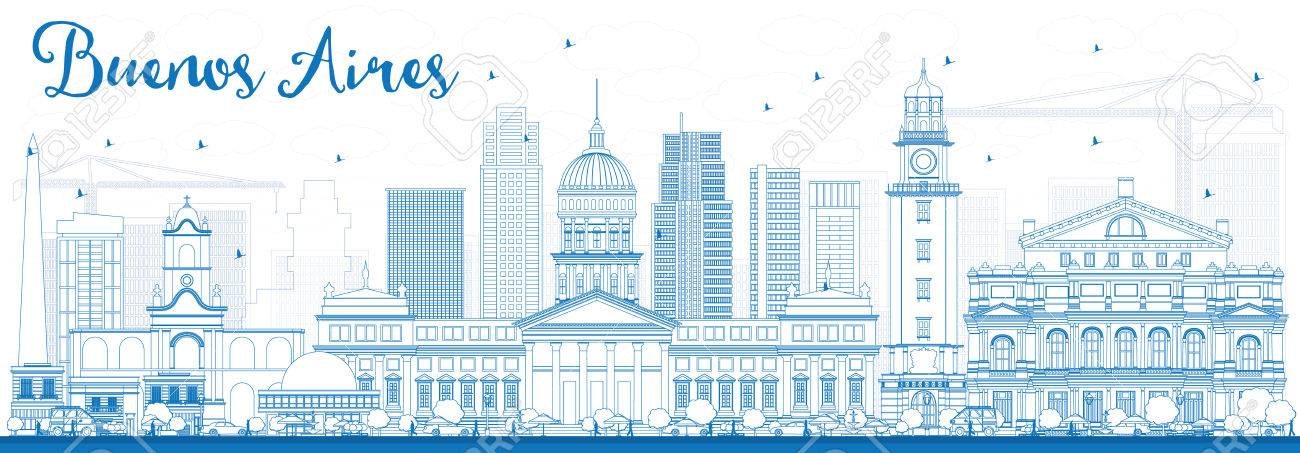

### For index to work please, click [here](https://nbviewer.jupyter.org/github/staskarasev/DeposBA/blob/master/DeposBA.ipynb)


# Index (click to redirect to section)

## [Data Pre-processing](#data-preprocessing)
- [clean the data](#clean-the-data)
 - [information and name](#information-and-name)
 - [price](#price)
 - [covered square](#covered-square)



# Gathering data:

Please see gather_data.ipynb for methods. This can be found it [this github repository](https://github.com/staskarasev/DeposBa).

## Data Pre-processing

Here we read the data and get a first insight into it.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import geopandas as gpd
import re 

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import folium
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

import warnings 
warnings.filterwarnings("ignore")

init_notebook_mode(connected=True)

plt.style.use('seaborn')

In [2]:
data = pd.read_csv('depos.csv')
data.head(2)

,Unnamed: 0,rooms,age,district,bathrooms,information,parking_lots,bedrooms,expenses,name,price,covered_square,total_square,toilets
0,0,2,Frente,Belgrano,0,"\n\t\t\n\t\t\n\t\t,Cantidad dormitorios: ,2,\n...",2,1,$ 7.000,Departamento · 102m² · 3 Ambientes,298000.0,3,102,3
1,1,4,Frente,Caballito,4,"\n\t\t\n\t\t\n\t\t,Cantidad pisos en edificio:...",1,3,$ 9.900,Departamento · 141m² · 4 Ambientes · 1 Cochera,490000.0,141m²,154,9


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16634 entries, 0 to 16633
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      16634 non-null  int64  
 1   rooms           16630 non-null  object 
 2   age             13590 non-null  object 
 3   district        16634 non-null  object 
 4   bathrooms       16622 non-null  object 
 5   information     16355 non-null  object 
 6   parking_lots    16553 non-null  object 
 7   bedrooms        16067 non-null  object 
 8   expenses        10024 non-null  object 
 9   name            16634 non-null  object 
 10  price           16634 non-null  float64
 11  covered_square  16634 non-null  object 
 12  total_square    16634 non-null  int64  
 13  toilets         14787 non-null  object 
dtypes: float64(1), int64(2), object(11)
memory usage: 1.8+ MB


In [4]:
data.drop('Unnamed: 0', axis=1, inplace=True) # drop Unnamed column
print('Missing data: ')
print(data.isna().sum())# NaN values

Missing data: 
rooms                4
age               3044
district             0
bathrooms           12
information        279
parking_lots        81
bedrooms           567
expenses          6610
name                 0
price                0
covered_square       0
total_square         0
toilets           1847
dtype: int64


<a id="clean-the-data"></a>
## Cleaning the data

Here we need to do:

* Trasform, extract some data from <code>information</code> and <code>name</code> columns.

* Create new variables (floors_per_building, swimming_pool, gym, sum, security) that can be useful for price inference.

* Deal with <code>NaN</code> values

* Drop outliers

* Convert string data into numeric data

<a id="information-and-name"></a>

### 'information' and 'name' 

In [5]:
data.information[0] # example of data in the information column

'\n\t\t\n\t\t\n\t\t,Cantidad dormitorios: ,2,\n\t\t\n\t\t\n\t\t\n\t\t,Superficie del terreno (m²): ,0,\n\t\t\n\t\t\n\t\t\n\t\t,Pileta ,\n\t\t\n\t\t\n\t,\n\t\t\n\t\t\n\t\t,Gas natural ,\n\t\t\n\t\t\n\t\t\n\t\t,Luz ,\n\t\t\n\t\t\n\t\t\n\t\t,Agua corriente ,\n\t\t\n\t\t\n\t\t\n\t\t,Pavimento ,\n\t\t\n\t\t\n\t,\n\t\t\n\t\t\n\t\t,Cocina ,\n\t\t\n\t\t\n\t\t\n\t\t,Lavadero ,\n\t\t\n\t\t\n\t\t\n\t\t,Balcón ,\n\t\t\n\t\t\n\t\t\n\t\t,Living comedor ,\n\t\t\n\t\t\n\t\t\n\t\t,Hall ,\n\t\t\n\t\t\n\t,\n\t\t\n\t\t\n\t\t,Calefacción ,\n\t\t\n\t\t\n\t\t\n\t\t,SUM ,\n\t\t\n\t\t\n\t'

In [6]:
def info_extracter(line):
    """Auxiliary function designed for extracting string values from information column
    
    Parameters:
    ===========
    line - A line with un pre-processed data.
    
    Output:
    ==========
    List of processed string values.
    """
    
    # Removes tabs, spaces and extra commas
    line = line.replace('\t','').replace('\n','').replace(',',' ').strip()
    
    # Extracts values we are interested in 
    regex =  r"Cantidad dormitorios:  \d|Cantidad pisos en edificio:  \d|Departamentos por piso:  \d|Pileta|Gimnasio|SUM|Vigilancia"
    line = re.findall(regex, line)
    
    return str(line)

In [7]:
data.information = data.information.astype('str')
data.name = data.name.astype('str')

data.information = data.information.map(lambda x: info_extracter(x))
data.sample(2)

,rooms,age,district,bathrooms,information,parking_lots,bedrooms,expenses,name,price,covered_square,total_square,toilets
13612,1,6,Villa del Parque,1,['Cantidad dormitorios: 1'],0,1,$ 1.800,Departamento · 30m² · 1 Ambiente,105700.0,30m²,37,0
56,1,4,Barracas,1,"['Cantidad dormitorios: 1', 'Gimnasio', 'Pile...",0,0,$ 4.300,Departamento · 37m² · 1 Ambiente,85000.0,37m²,37,0


Column <code>name</code> has some useful information like:

* covered square of department

* rooms quantity

* parking lots

I will create new columns with this values for double check.

In [8]:
# extracting values from name column
data['parking_lots_2'] = data.name.str.extract(r'(\d+)\s*Cochera?\b')
data['bedrooms_2'] = data.information.str.extract(r'dormitorios\W\s+(\d+)')
data['rooms_2'] = data.name.str.extract(r'(\d+)\s*Ambientes?\b')
data['covered_square_2'] = data.name.str.extract(r'(\d+)m²')

# extracting values from information column
data['floors_per_building'] = data.information.str.extract(r'\w{2}\s\w{8}\W\s+(\d+)')
data['swimming_pool'] = data.information.str.extract(r'(Pileta)')
data['gym'] = data.information.str.extract(r'(Gimnasio)') 
data['sum'] = data.information.str.extract(r'(SUM)')
data['security'] = data.information.str.extract(r'(Vigilancia)')

# converting values to Dummies
data['swimming_pool'] = data['swimming_pool'].map({'Pileta':'1'})
data['gym'] = data['gym'].map({'Gimnasio':'1'})
data['sum'] = data['sum'].map({'SUM':'1'})
data['security'] = data['security'].map({'Vigilancia':'1'})

dummies = ['swimming_pool', 'gym', 'sum', 'security','floors_per_building']

for x in dummies:
    data[x].fillna('0',inplace=True)
    data[x] = data[x].astype('int')

data.drop(['information','name'], axis=1, inplace=True) # and finally drop "name" and "information"
data.sample(2)

,rooms,age,district,bathrooms,parking_lots,bedrooms,expenses,price,covered_square,total_square,toilets,parking_lots_2,bedrooms_2,rooms_2,covered_square_2,floors_per_building,swimming_pool,gym,sum,security
2271,4,NO,Recoleta,2,3,65,$ 42.000,495000.0,166m²,166,Frente,NaN,NaN,4,166,1,0,0,0,0
8942,4,NE,Retiro,3,2,85,$ 38.402,960000.0,254m²,254,Frente,NaN,NaN,4,254,3,0,0,0,1


<a id="price"></a>

### Price

Things to do:

* convert price in thousands

* drop outliers

In [9]:
# Converting in thousands
data.price = data.price / 1000
data.price.describe()

count     16634.000000
mean        399.618625
std        1453.564183
min           0.000000
25%         125.000000
50%         191.262500
75%         349.000000
max      111111.111000
Name: price, dtype: float64

There are a lot of prices with zero values, I will set to limits:

* I will drop prices less than 10k.

* I will drop prices above 97.5 percentile

In [19]:
# set price limits
min_price = 10 
max_price = np.percentile(data.price, 97.5)

print('Price 97.5% percentile: ' + str(max_price) + ' ' + 'thousands USD')
print(data.shape)

# list of indexes of rows to drop.
to_drop = list(data[(data.price <= min_price) | (data.price >= max_price)].index) 

# drop coiumn and reset index
data.drop(to_drop, inplace=True)
data.reset_index(drop=True, inplace=True)
print(data.shape)

Price 97.5% percentile: 1100.0 thousands USD
(15757, 20)
(15326, 20)


<a id="covered-square"></a>
### 'covered_square' and 'covered_square_2'

In [ ]:
print(data.covered_square.isna().sum())
print(data.covered_square_2.isna().sum())

In [ ]:
data.covered_square = data.covered_square.str.replace('m²','')
data.covered_square = data.covered_square.str.replace('ha','')

data.covered_square = data.covered_square.astype(int)
data.covered_square_2 = data.covered_square_2.fillna(0)
data.covered_square_2 = data.covered_square_2.astype(int)

In [ ]:
data.covered_square.describe()

In [ ]:
data.covered_square_2.describe()

In [ ]:
"""
I'm going to drop all apartments that has less than 20 square meters. As we have two columns with this values,
I need to drop one. covered_square_2 has less values to drop, so I leave it.
"""
print(data[data.covered_square < 20].shape) # 872 values to drop
print(data[data.covered_square_2 < 20].shape) # 76 values to drop

min_limit = 20 
max_limit = np.percentile(data.covered_square_2, 99.5)

# drop all rows that are outside of our interval.
to_drop = list(data[(data.covered_square_2 <= min_limit) | (data.covered_square_2 >= max_limit)].index)
data.drop(to_drop, inplace=True)
data.reset_index(drop=True, inplace=True)
print(data.shape)

In [ ]:
data.covered_square = data.covered_square_2
data.drop('covered_square_2', axis=1, inplace=True)

data.covered_square.describe()

### Rooms 

In [ ]:
print('Number of NaN in rooms column: ' + str(data.rooms.isna().sum()))
print('Unique values of rooms column: ' + str(data.rooms.unique()))
print('\n')
print('=' * 20)
print('\n')
print('Number of NaN in rooms_2 column: ' + str(data.rooms_2.isna().sum()))
print('Unique values of rooms_2 column: ' + str(data.rooms_2.unique()))

In [ ]:
data.rooms = data.rooms_2
data.drop('rooms_2', axis=1, inplace = True)
data.rooms = pd.to_numeric(data.rooms, downcast='integer')#delete

### Age

In [ ]:
print(data.age.isna().sum())
print(data.age.unique())

In [ ]:
# List of value to filter
filter_ = ['Frente', 'En consrucción', 'Muy luminoso','Excelente',
          'E', 'Muy bueno', 'Interno', 'Contrafrente', 'Reciclado',
          'Luminoso', 'A refaccionar', 'Lateral', 'NO', 'Bueno',
           'regular', 'muy_luminoso', 'Poco luminoso', 'En construcción',
          'N','NE','Regular','SE','SO','O','S', 'A estrenar', '350' , '500']

indexes = []

# loop to extract indexes with string values
for index, value in enumerate(data.age):
    if value in filter_:
        indexes.append(index)
print(len(indexes))

data.age.iloc[indexes] = np.nan # convert all string values to NaN
data.age.fillna(np.NaN, inplace=True)

data.age = pd.to_numeric(data.age, downcast='integer')

# Changing some values manualy
data.age = data.age.replace(2008, 12)
data.age = data.age.replace(1981, 39)
data.age = data.age.replace(1948, 72)

print(data.age.isna().sum())

### District

In [ ]:
data.district = data.district.map(lambda x: x.strip()) # get rid of spaces
data.district = data.district.replace("['nan']", 'Otro')

In [ ]:
# drops all rows, where the total num of values in the neighbourhood is less then 10 - as no representive
data = data.groupby('district').filter(lambda x: len(x) >= 10).reset_index(drop=True)

# changes some names in the neighbourhood column
data.district = data.district.replace('Palermo Chico', 'Palermo')
data.district = data.district.replace('Palermo Hollywood', 'Palermo')
data.district = data.district.replace('Palermo Soho', 'Palermo')
data.district = data.district.replace('Palermo Viejo', 'Palermo')
data.district = data.district.replace('Palermo Nuevo', 'Palermo')
data.district = data.district.replace('Las Cañitas', 'Palermo')
data.district = data.district.replace('Abasto', 'Balvanera')
data.district = data.district.replace('Once', 'Balvanera')
data.district = data.district.replace('Barrio Norte', 'Recoleta')
data.district = data.district.replace('Boca', 'La Boca')
data.district = data.district.replace('Parque Centenario', 'Villa Crespo')
data.district = data.district.replace('Centro / Microcentro', 'Centro')

# change type to category

data.district = data.district.astype('category')
print(data.shape)

### Bathrooms

In [ ]:
print(data.bathrooms.unique())
print(data.bathrooms.isna().sum())

In [ ]:
# list of values to filter
filter_ = ['Frente', '60', '80', '90', '30', '45', 'En construcción',
          '40', 'Contrafrente', '70', '35', '50', 'A estrenar', 'Bueno',
          'Lateral','72', '23', 'Excelente', 'Muy bueno', 'Muy luminoso','15', '11']

indexes = []

# loop to extract indexes with string values
for index, value in enumerate(data.bathrooms):
    if value in filter_:
        indexes.append(index)

data.bathrooms.iloc[indexes] = np.nan # convert all string values to NaN
data.bathrooms.fillna(np.NaN, inplace=True)
data.bathrooms = pd.to_numeric(data.bathrooms)

print(data.bathrooms.isna().sum())

### Parking Lots

In [ ]:
print(data.parking_lots.unique())
print('\n')
print(data.parking_lots.isna().sum())
print('=' * 20)
print(data.parking_lots_2.unique())
print('\n')
print(data.parking_lots_2.isna().sum())

In [ ]:
print(data.parking_lots.value_counts()[:5])

In [ ]:
filter_ = ['0', '1', '2', '3']

indexes = []

for index, value in enumerate(data.parking_lots):
    if value not in filter_:
        indexes.append(index)
        
data.parking_lots.iloc[indexes] = np.nan # convert all string values to NaN
data.parking_lots.fillna(np.NaN, inplace=True)
data.parking_lots = pd.to_numeric(data.parking_lots)

data.drop('parking_lots_2', axis=1, inplace=True)

print(data.parking_lots.unique())
print(data.parking_lots.isna().sum())

### Bathrooms Columns

In [ ]:
print(data.bedrooms.unique())
print(data.bedrooms.isna().sum())
print('\n')
print(data.bedrooms_2.unique())
print(data.bedrooms_2.isna().sum())

In [ ]:
data.bedrooms = data.bedrooms_2
data.bedrooms = pd.to_numeric(data.bedrooms)
data.drop('bedrooms_2', axis = 1, inplace=True)

### Expenses

In [ ]:
data.expenses = data.expenses.map(lambda x: str(x))
data.expenses = data.expenses.map(lambda x: x.replace('.',''))
data.expenses = data.expenses.str.extract(r"(\d+)")

data.expenses = pd.to_numeric(data.expenses)

data['expenses_per_m2'] = data.expenses / data.covered_square # new feature 

data.expenses = data.expenses / 1000
data.loc[data['expenses'] > 135,'expenses'] = np.NaN


### Toilets

In [ ]:
print(data.toilets.unique())
print(data.toilets.isna().sum())
print(data.groupby('toilets')['toilets'].count().sort_values(ascending=False)[:5])

data.drop('toilets', axis=1, inplace=True)

### Total_square

In [ ]:
min_limit = 20
max_limit = 700

data.loc[(data.total_square < min_limit) | (data.total_square > max_limit), 'total_square'] = np.NaN

In [ ]:
data['price_per_m2'] = data.price / data.covered_square


In [ ]:
data.columns

In [ ]:
data.info()

In [ ]:
pd.to_numeric(data.age)

### EDA

In [ ]:
corr = data.corr()

corr['price'].sort_values(ascending=False)

In [ ]:
corr = data.corr()

# figure
fig, ax = plt.subplots(figsize=(15,10))

# color map
cmap = sns.diverging_palette(30, 230, 90, 60, as_cmap=True)

# plt heatmap
g = sns.heatmap(corr, 
                cmap=cmap, 
                annot=True, 
                fmt=".2f", 
                linewidths=1,
                square=True, 
                cbar_kws={'fraction' : 0.01},
                mask = corr < 0.2)

g.set_xticklabels(g.get_xticklabels(),
                  rotation=45, 
                  horizontalalignment='right',
                  fontweight='light',
                  fontsize='x-large'
                 )
g.set_yticklabels(g.get_yticklabels(), 
                  rotation=45, 
                  horizontalalignment='right',
                  fontweight='light',
                  fontsize='x-large')

In [ ]:
fig = plt.figure(figsize=(18,16))
for index,col in enumerate(data.drop('district', axis=1).dropna()):
    plt.subplot(6,4,index+1)
    sns.distplot(data.loc[:,col].dropna(), kde=False)
fig.tight_layout(pad=1.0)

In [ ]:
fig = px.strip(data, x='district', y='price_per_m2', color='district')
fig.show()

In [ ]:
fig = px.box(data, x = 'district', y="price_per_m2", color='district')
fig.show()

In [ ]:
prices = data.groupby('district')['price_per_m2'].mean().to_frame()
barrios = gpd.read_file('barrios.geojson')

prices = prices.reset_index()
prices.columns = ['name', 'price']

In [ ]:
def replacer(word):
    
    word = word.replace('í', 'i')
    word = word.replace('ó', 'o')
    word = word.replace('ú', 'u')
    word = word.replace('é', 'e')
    
    return word

In [ ]:
prices.name = prices.name.apply(lambda x: replacer(x))
barrios.name = barrios.name.apply(lambda x: replacer(x))

In [ ]:
m = folium.Map([-34.6083, -58.3712], zoom_start=12)

folium.Choropleth(
    geo_data=barrios,
    data=prices,
    columns=['name', 'price'],
    key_on='feature.properties.name',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.3,
    nan_fill_color='purple',
    nan_fill_opacity=0.4,
    legend_name='Average price per meter (1000$)',
    highlight=True,
).add_to(m)

folium.map.CustomPane("labels").add_to(m)

folium.TileLayer("CartoDBPositronOnlyLabels", pane="labels").add_to(m)

In [ ]:
display(m)

In [ ]:
import statsmodels.formula.api as smf

def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return model

In [ ]:
df = data.dropna().copy()

df['log_price'] = df.price.apply(lambda x: np.log(x))
df = df.drop(['price_per_m2','price'], axis=1)
df = df.reset_index(drop=True)
df = pd.get_dummies(df)
df.shape

columns = df.columns.to_list()
new_columns = []
for col in columns:
    col = col.replace(' ', '_')
    new_columns.append(col)

df.columns = new_columns

model = forward_selected(df, 'log_price')

In [ ]:
print(model.summary())